# Analysis notebook of current injection simulations

ℹ️ Reproduction of interneuron rewiring results described in [Pokorny et al. (2024)](https://doi.org/10.1101/2024.05.24.593860)

<u>Requirements</u>:
- [BlueETL](https://github.com/BlueBrain/blueetl) (Python venv)
- [Blue Brain SNAP](https://github.com/BlueBrain/snap) (Python venv)
- [CortexETL](https://github.com/BlueBrain/cortexetl) (Cloned repo)
- Simulation results (available on [Zenodo](https://zenodo.org/); see instructions in `README.md` on how to rerun the simulations)

In [3]:
from bluepysnap import Simulation
import numpy as np
import matplotlib.pyplot as plt
import os

ℹ️ Set path to cloned CortexETL repository below

In [4]:
# Set path to cloned CortexETL repository
import sys
sys.path.append('/gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/cortex_etl')
import cortex_etl as c_etl

In [5]:
# Set and create output figures folder
sim_spec = "Ca1p05_Pfr0p3_Rou0p4"
figs_path = f"./cetl_figs_{sim_spec}"
if not os.path.exists(figs_path):
    os.makedirs(figs_path)

Run data analysis using CortexETL

ℹ️ Before running the analyses, set paths in `../configs/cortexetl_analysis_config__orig_<...>.yaml` accordingly:
- "simulation_campaign" ... pointing to `config.json` from respective simulation campaign
  - In `config.json`: Make sure that "path_prefix" is pointing to actual simulation campaign folder!
- "output" ... pointing to some output results folder

In [7]:
# Run (or reload) analysis
ma_orig = c_etl.run_from_file(f"../configs/cortexetl_analysis_config__orig_{sim_spec}.yaml", loglevel="WARNING")
ma_manip = c_etl.run_from_file(f"../configs/cortexetl_analysis_config__manip_{sim_spec}.yaml", loglevel="WARNING")

ModuleNotFoundError: No module named 'calculate_features'

In [4]:
# Plot spike trains & rates
sim_cond = "curr_inj_amp_nA"
assert [sim_cond] == ma_orig.spikes.repo.simulations_config.conditions == ma_manip.spikes.repo.simulations_config.conditions, "ERROR: Sim condition mismatch!"
sims_orig = ma_orig.spikes.repo.simulations_config.data
sims_manip = ma_manip.spikes.repo.simulations_config.data

cond_val = sims_orig[sim_cond].values
assert np.array_equal(cond_val, sims_orig[sim_cond].values), "ERROR: Condition value mismatch!"
print(f"{sim_cond}: {', '.join([str(_v) for _v in cond_val])}")

curr_inj_amp_nA: 0.05, 0.1, 0.15, 0.2, 0.25


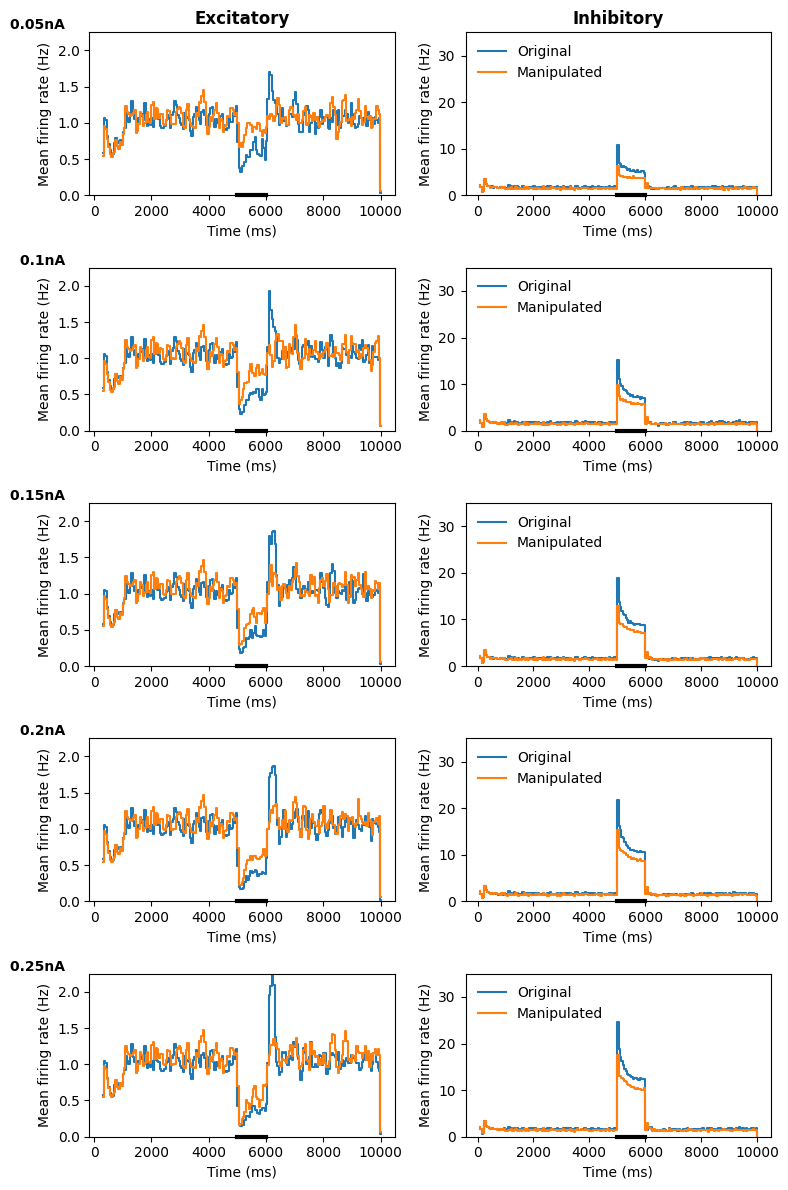

In [5]:
# Manipulated vs. original
exc_max = 2.25  # Hz
inh_max = 35.0  # Hz
binsize = 50  # ms
plt.figure(figsize=(8, 12))
for idx, val in enumerate(cond_val):
    sim_cfg = sims_orig.etl.one({sim_cond: val}).simulation_path
    sim_orig = Simulation(sim_cfg)
    sim_cfg = sims_manip.etl.one({sim_cond: val}).simulation_path
    sim_manip = Simulation(sim_cfg)
    inj_cfg = sim_orig.config["inputs"]["Stimulus_CurrentInject_L23_BTC"]
    inj_start = inj_cfg["delay"]
    inj_end = inj_start + inj_cfg["duration"]

    plt.subplot(len(cond_val), 2, 2 * idx + 1)
    ax = plt.gca()
    spk_exc_orig = sim_orig.spikes.filter("Excitatory")
    spk_exc_manip = sim_manip.spikes.filter("Excitatory")
    spk_exc_orig.firing_rate_histogram(ax=ax, time_binsize=binsize)
    spk_exc_manip.firing_rate_histogram(ax=ax, time_binsize=binsize)
    if exc_max is not None:
        plt.ylim([0, exc_max])
    plt.plot([inj_start, inj_end], [np.min(plt.ylim())] * 2, "k", lw=3, clip_on=False)
    plt.xlabel("Time (ms)")
    plt.ylabel("Mean firing rate (Hz)")
    if idx == 0:
        plt.title("Excitatory", fontweight="bold")
    plt.text(np.min(plt.xlim()), np.max(plt.ylim()), f"{val}nA     ", ha="right", va="bottom", fontweight="bold")
    
    plt.subplot(len(cond_val), 2, 2 * idx + 2)
    ax = plt.gca()
    spk_inh_orig = sim_orig.spikes.filter("Inhibitory")
    spk_inh_manip = sim_manip.spikes.filter("Inhibitory")
    spk_inh_orig.firing_rate_histogram(ax=ax, time_binsize=binsize)
    spk_inh_manip.firing_rate_histogram(ax=ax, time_binsize=binsize)
    if inh_max is not None:
        plt.ylim([0, inh_max])
    plt.plot([inj_start, inj_end], [np.min(plt.ylim())] * 2, "k", lw=3, clip_on=False, zorder=0)
    plt.xlabel("Time (ms)")
    plt.ylabel("Mean firing rate (Hz)")
    if idx == 0:
        plt.title("Inhibitory", fontweight="bold")
    plt.legend(ax.lines[:2], ["Original", "Manipulated"], frameon=False, loc="upper left")
plt.savefig(os.path.join(figs_path, "rate_histograms.png"), dpi=300)
plt.tight_layout()
plt.show()


Bin size: [  1.   3.   5.  10. 100.]
Smoothing type: ['None' 'Gaussian']
Kernel SD: [-1.  1.  3.  5. 10.]


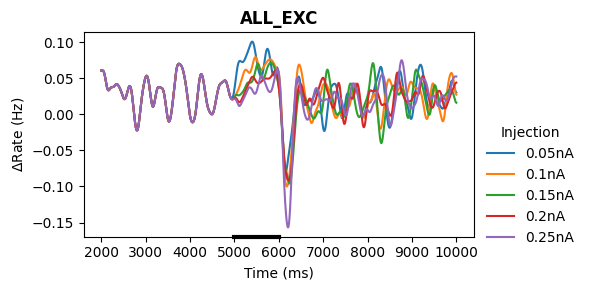

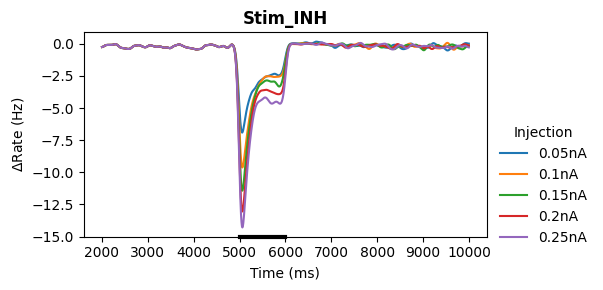

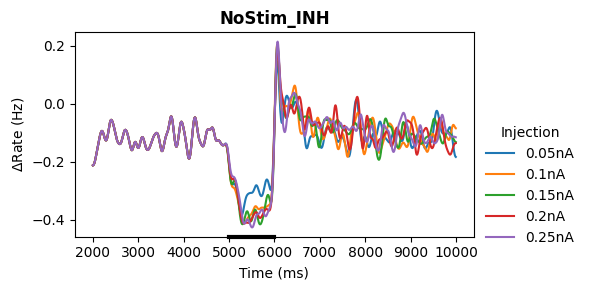

In [6]:
# BlueETL histograms
import scipy
hist_df_orig = ma_orig.spikes.features.histograms.df
hist_df_manip = ma_manip.spikes.features.histograms.df

# Available histograms
print(f'Bin size: {hist_df_orig["bin_size"].unique()}')
print(f'Smoothing type: {hist_df_orig["smoothing_type"].unique()}')
print(f'Kernel SD: {hist_df_orig["kernel_sd"].unique()}')

window_name = "w_all"
window = ma_orig.spikes.extraction.windows.get_bounds(window_name)
assert np.array_equal(window, ma_manip.spikes.extraction.windows.get_bounds(window_name))

bin_size = 5 # (ms)
# smoothing_type = "None"
# kernel_sd = -1.0
smoothing_type = "Gaussian"
kernel_sd = 10.0

t = np.arange(*window, bin_size) + 0.5 * bin_size

inj_window_name = "w2_inj"
inj_window = ma_orig.spikes.extraction.windows.get_bounds(inj_window_name)
assert np.array_equal(inj_window, ma_manip.spikes.extraction.windows.get_bounds(inj_window_name))

# mav_len = 100  # Moving average filter length (ms)
# for nrn_class in ["ALL_EXC", "Stim_INH", "NoStim_INH"]:
for nrn_class in ["ALL_EXC", "Stim_INH", "NoStim_INH"]:
    plt.figure(figsize=(6, 3))
    for idx, val in enumerate(cond_val):
        # h_data_orig = hist_df_orig.etl.q(simulation_id=idx, neuron_class=nrn_class, window=window_name)[f"spike_times_normalised_hist_{bin_size}ms_bin"].values
        # h_data_manip = hist_df_manip.etl.q(simulation_id=idx, neuron_class=nrn_class, window=window_name)[f"spike_times_normalised_hist_{bin_size}ms_bin"].values
        h_data_orig = hist_df_orig.etl.q(simulation_id=idx, neuron_class=nrn_class, window=window_name, bin_size=bin_size, smoothing_type=smoothing_type, kernel_sd=kernel_sd)["hist"].values
        h_data_manip = hist_df_manip.etl.q(simulation_id=idx, neuron_class=nrn_class, window=window_name, bin_size=bin_size, smoothing_type=smoothing_type, kernel_sd=kernel_sd)["hist"].values

        h_data_orig = h_data_orig / (bin_size * 1e-3)
        h_data_manip = h_data_manip / (bin_size * 1e-3)

#         h_data_orig = scipy.ndimage.convolve1d(h_data_orig, np.ones(mav_len) / mav_len)
#         h_data_manip = scipy.ndimage.convolve1d(h_data_manip, np.ones(mav_len) / mav_len)

        plt.plot(t, h_data_manip - h_data_orig, label=f"{val}nA")
    plt.ylim(plt.ylim())
    plt.plot(inj_window, [np.min(plt.ylim())] * 2, "k", lw=3, clip_on=False, zorder=0)
    plt.xlabel("Time (ms)")
    plt.ylabel("$\Delta$Rate (Hz)")
    plt.title(nrn_class, fontweight="bold")
    plt.legend(title="Injection", frameon=False, loc="lower left", bbox_to_anchor=[1.0, -0.1])
    plt.tight_layout()
    plt.savefig(os.path.join(figs_path, f"BlueETL_delta_rate_{nrn_class}.png"), dpi=300)
    plt.show()

In [ ]:
# BlueETL histograms
import scipy
hist_df_orig = ma_orig.spikes.features.histograms.df
hist_df_manip = ma_manip.spikes.features.histograms.df

window_name = "w_all"
window = ma_orig.spikes.extraction.windows.get_bounds(window_name)
assert np.array_equal(window, ma_manip.spikes.extraction.windows.get_bounds(window_name))
bin_size = 1 # (ms)
t = np.arange(*window, bin_size) + 0.5 * bin_size

inj_window_name = "w2_inj"
inj_window = ma_orig.spikes.extraction.windows.get_bounds(inj_window_name)
assert np.array_equal(inj_window, ma_manip.spikes.extraction.windows.get_bounds(inj_window_name))

mav_len = 100  # Moving average filter length (ms)
for nrn_class in ["ALL_EXC", "Stim_INH", "NoStim_INH"]:
    plt.figure(figsize=(6, 3))
    for idx, val in enumerate(cond_val):
        h_data_orig = hist_df_orig.etl.q(simulation_id=idx, neuron_class=nrn_class, window=window_name)[f"spike_times_normalised_hist_{bin_size}ms_bin"].values
        h_data_manip = hist_df_manip.etl.q(simulation_id=idx, neuron_class=nrn_class, window=window_name)[f"spike_times_normalised_hist_{bin_size}ms_bin"].values

        h_data_orig = h_data_orig / (bin_size * 1e-3)
        h_data_manip = h_data_manip / (bin_size * 1e-3)

        h_data_orig = scipy.ndimage.convolve1d(h_data_orig, np.ones(mav_len) / mav_len)
        h_data_manip = scipy.ndimage.convolve1d(h_data_manip, np.ones(mav_len) / mav_len)

        plt.plot(t, 100 * (h_data_manip - h_data_orig) / h_data_orig, label=f"{val}nA")
    plt.ylim(plt.ylim())
    plt.plot(inj_window, [np.min(plt.ylim())] * 2, "k", lw=3, clip_on=False, zorder=0)
    plt.xlabel("Time (ms)")
    plt.ylabel("Rel. rate diff. (%)")
    plt.title(nrn_class, fontweight="bold")
    plt.legend(title="Injection", frameon=False, loc="lower left", bbox_to_anchor=[1.0, -0.1])
    plt.tight_layout()
    plt.savefig(os.path.join(figs_path, f"BlueETL_rel_rate_change_{nrn_class}.png"), dpi=300)
    plt.show()

In [ ]:
# BlueETL histograms

mav_len = 100  # Moving average filter length (ms)

# nrn_class = "ALL_EXC"
# ymax = 0.2 # (Hz)
# nrn_class = "ALL_INH"
# ymax = 10.0 # (Hz)
# nrn_class = "Stim_INH"
# ymax = 65.0 # (Hz)
# nrn_class = "NoStim_INH"
# ymax = 1.0 # (Hz)

# for nrn_class, ymax in zip(["ALL_EXC", "Stim_INH", "NoStim_INH"], [0.2, 65.0, 1.0]):
for nrn_class, ymax in zip(["ALL_EXC", "Stim_INH", "NoStim_INH"], [0.4, 65.0, 1.5]):
    plt.figure(figsize=(4, 10))
    for idx, val in enumerate(cond_val):
        h_data_orig = hist_df_orig.etl.q(simulation_id=idx, neuron_class=nrn_class, window=window_name)[f"spike_times_normalised_hist_{bin_size}ms_bin"].values
        h_data_manip = hist_df_manip.etl.q(simulation_id=idx, neuron_class=nrn_class, window=window_name)[f"spike_times_normalised_hist_{bin_size}ms_bin"].values

        h_data_orig = h_data_orig / (bin_size * 1e-3)
        h_data_manip = h_data_manip / (bin_size * 1e-3)

        h_data_orig = scipy.ndimage.convolve1d(h_data_orig, np.ones(mav_len) / mav_len)
        h_data_manip = scipy.ndimage.convolve1d(h_data_manip, np.ones(mav_len) / mav_len)

        plt.subplot(len(cond_val), 1, idx + 1)
        plt.plot(t, h_data_orig, label="Orig")
        plt.plot(t, h_data_manip, "--", label="Manip")
        plt.title(f"{nrn_class}: {val}nA", fontweight="bold")
        if ymax is not None:
            plt.ylim([0, ymax])
        plt.plot(inj_window, [np.min(plt.ylim())] * 2, "k", lw=3, clip_on=False, zorder=0)
        plt.xlabel("Time (ms)")
        plt.ylabel("Rate (Hz)")
        plt.legend(frameon=False)
    plt.tight_layout()
    plt.savefig(os.path.join(figs_path, f"BlueETL_abs_rates_{nrn_class}_{val}nA.png"), dpi=300)
    plt.show()

In [ ]:
# Plot extracted features
ftr_df_orig = ma_orig.spikes.features.by_neuron_class.df
ftr_df_manip = ma_manip.spikes.features.by_neuron_class.df

# for wnd_name in ma_orig.spikes.analysis_config.extraction.windows.keys():
for wnd_name in ["w1_spont", "w2_inj", "w3_rec", "w4_spont"]:
    window = np.round(np.array(ma_orig.spikes.extraction.windows.get_bounds(wnd_name)) * 1e-3).astype(int)  # (s)
    window_type = ma_orig.spikes.repo.windows.df.etl.first(window=wnd_name)["window_type"]

    # for nrn_class in ma_orig.spikes.analysis_config.extraction.neuron_classes.keys():
    # for nrn_class in ["ALL_EXC", "Stim_INH", "NoStim_INH"]:
    for nrn_class in ["ALL_EXC", "Stim_INH", "Stim_L23_INH", "Stim_L4_INH", "Stim_L5_INH", "Stim_L6_INH", "NoStim_INH", "NoStim_L1_INH", "NoStim_L23_INH", "NoStim_L4_INH", "NoStim_L5_INH", "NoStim_L6_INH"]:
        r_data_orig = ftr_df_orig.etl.q(neuron_class=nrn_class, window=wnd_name)["mean_of_mean_firing_rates_per_second"]
        r_data_manip = ftr_df_manip.etl.q(neuron_class=nrn_class, window=wnd_name)["mean_of_mean_firing_rates_per_second"]

        plt.figure(figsize=(4, 2))
        plt.plot(cond_val, r_data_orig.values, 's-', label="Orig")
        plt.plot(cond_val, r_data_manip.values, 'o--', label="Manip")
        plt.xticks(cond_val)
        plt.xlabel("Injection (nA)")
        plt.ylabel("Rate (Hz)")
        plt.title(f"{nrn_class}, {window[0]}-{window[1]}s ({window_type})", fontweight="bold", fontsize=8)
        plt.legend(loc="upper left", bbox_to_anchor=[1.0, 1.0], frameon=False, fontsize=8)
        plt.tight_layout()
        plt.savefig(os.path.join(figs_path, f"BlueETL_abs_rates_by_nA_{wnd_name}_{nrn_class}.png"), dpi=300)
        plt.show()

In [ ]:
# Plot extracted features
ftr_df_orig = ma_orig.spikes.features.by_neuron_class.df
ftr_df_manip = ma_manip.spikes.features.by_neuron_class.df

wnd_sel = ["w1_spont", "w2_inj", "w3_rec", "w4_spont"]
# for nrn_class in ["ALL_EXC", "Stim_INH", "NoStim_INH"]:
for nrn_class in ["ALL_EXC", "Stim_INH", "Stim_L23_INH", "Stim_L4_INH", "Stim_L5_INH", "Stim_L6_INH", "NoStim_INH", "NoStim_L1_INH", "NoStim_L23_INH", "NoStim_L4_INH", "NoStim_L5_INH", "NoStim_L6_INH"]:
    for idx, inj in enumerate(cond_val):

        r_data_orig = ftr_df_orig.etl.q(simulation_id=idx, neuron_class=nrn_class, window=wnd_sel)["mean_of_mean_firing_rates_per_second"]
        r_data_manip = ftr_df_manip.etl.q(simulation_id=idx, neuron_class=nrn_class, window=wnd_sel)["mean_of_mean_firing_rates_per_second"]

        plt.figure(figsize=(4, 2))
        plt.plot(wnd_sel, r_data_orig.values, 's-', label="Orig")
        plt.plot(wnd_sel, r_data_manip.values, 'o--', label="Manip")
        plt.xlabel("Window")
        plt.ylabel("Rate (Hz)")
        plt.title(f"{nrn_class}, {inj}nA", fontweight="bold", fontsize=8)
        plt.legend(loc="upper left", bbox_to_anchor=[1.0, 1.0], frameon=False, fontsize=8)
        plt.tight_layout()
        plt.savefig(os.path.join(figs_path, f"BlueETL_abs_rates_by_wnd_{nrn_class}_{inj}nA.png"), dpi=300)
        plt.show()

In [ ]:
# Plot extracted features
ftr_df_orig = ma_orig.spikes.features.by_neuron_class.df
ftr_df_manip = ma_manip.spikes.features.by_neuron_class.df

wnd_sel = ["w1_spont", "w2_inj", "w3_rec", "w4_spont"]
# for nrn_class in ["ALL_EXC", "ALL_INH"]:
for nrn_class in ma_orig.spikes.analysis_config.extraction.neuron_classes.keys():
    plt.figure(figsize=(4, 2))
    for idx, inj in enumerate(cond_val):

        r_data_orig = ftr_df_orig.etl.q(simulation_id=idx, neuron_class=nrn_class, window=wnd_sel)["mean_of_mean_firing_rates_per_second"]
        r_data_manip = ftr_df_manip.etl.q(simulation_id=idx, neuron_class=nrn_class, window=wnd_sel)["mean_of_mean_firing_rates_per_second"]

        plt.plot(r_data_manip.values - r_data_orig.values, '.-', label=f"{inj}nA")
    plt.gca().set_xticks(range(r_data_orig.shape[0]), r_data_orig.etl.labels_of("window").values, rotation=0)
    plt.ylabel("$\Delta$Rate (Hz)")
    plt.title(f"{nrn_class}", fontweight="bold", fontsize=8)
    plt.xlim(plt.xlim())
    plt.plot(plt.xlim(), np.zeros(2), 'k-', alpha=0.5, lw=1, zorder=0)
    plt.legend(loc="upper left", bbox_to_anchor=[1.0, 1.0], frameon=False, fontsize=8)
    plt.tight_layout()
    plt.savefig(os.path.join(figs_path, f"BlueETL_delta_rate_by_wnd_{nrn_class}.png"), dpi=300)
    plt.show()

In [ ]:
# Plot extracted features
ftr_df_orig = ma_orig.spikes.features.by_neuron_class.df
ftr_df_manip = ma_manip.spikes.features.by_neuron_class.df

wnd_sel = ["w1_spont", "w2_inj", "w3_rec", "w4_spont"]
# for nrn_class in ["ALL_EXC", "ALL_INH"]:
for nrn_class in ma_orig.spikes.analysis_config.extraction.neuron_classes.keys():
    plt.figure(figsize=(4, 2))
    for idx, inj in enumerate(cond_val):

        r_data_orig = ftr_df_orig.etl.q(simulation_id=idx, neuron_class=nrn_class, window=wnd_sel)["mean_of_mean_firing_rates_per_second"]
        r_data_manip = ftr_df_manip.etl.q(simulation_id=idx, neuron_class=nrn_class, window=wnd_sel)["mean_of_mean_firing_rates_per_second"]

        plt.plot(100.0 * (r_data_manip.values - r_data_orig.values) / r_data_orig.values, '.-', label=f"{inj}nA")
    plt.gca().set_xticks(range(r_data_orig.shape[0]), r_data_orig.etl.labels_of("window").values, rotation=0)
    plt.ylabel("Rel. rate diff. (Hz)")
    plt.title(f"{nrn_class}", fontweight="bold", fontsize=8)
    plt.xlim(plt.xlim())
    plt.plot(plt.xlim(), np.zeros(2), 'k-', alpha=0.5, lw=1, zorder=0)
    plt.legend(loc="upper left", bbox_to_anchor=[1.0, 1.0], frameon=False, fontsize=8)
    plt.tight_layout()
    plt.savefig(os.path.join(figs_path, f"BlueETL_rel_rate_by_wnd_{nrn_class}.png"), dpi=300)
    plt.show()

In [ ]:
# Plot extracted features
ftr_df_orig = ma_orig.spikes.features.by_neuron_class.df
ftr_df_manip = ma_manip.spikes.features.by_neuron_class.df

wnd_sel = ["w1_spont", "w2_inj", "w3_rec", "w4_spont"]
for wnd in wnd_sel:
    for nrn_class in ["EXC", "INH"]:
        nrn_sel = list(filter(lambda c: nrn_class in c, ma_orig.spikes.analysis_config.extraction.neuron_classes.keys()))
        plt.figure(figsize=(6, 3))
        for idx, inj in enumerate(cond_val):

            r_data_orig = ftr_df_orig.etl.q(simulation_id=idx, neuron_class=nrn_sel, window=wnd)["mean_of_mean_firing_rates_per_second"]
            r_data_manip = ftr_df_manip.etl.q(simulation_id=idx, neuron_class=nrn_sel, window=wnd)["mean_of_mean_firing_rates_per_second"]

            plt.plot(r_data_manip.values - r_data_orig.values, '.-', label=f"{inj}nA")
        plt.gca().set_xticks(range(r_data_orig.shape[0]), r_data_orig.etl.labels_of("neuron_class").values, rotation=90)
        plt.ylabel("$\Delta$Rate (Hz)")
        plt.xlim(plt.xlim())
        plt.plot(plt.xlim(), np.zeros(2), 'k-', alpha=0.5, lw=1, zorder=0)
        plt.title(f"{wnd}", fontweight="bold", fontsize=8)
        plt.legend(loc="upper left", bbox_to_anchor=[1.0, 1.0], frameon=False, fontsize=8)
        plt.tight_layout()
        plt.savefig(os.path.join(figs_path, f"BlueETL_delta_rate_by_type_{wnd}_{nrn_class}.png"), dpi=300)
        plt.show()

In [ ]:
# Plot extracted features
ftr_df_orig = ma_orig.spikes.features.by_neuron_class.df
ftr_df_manip = ma_manip.spikes.features.by_neuron_class.df

wnd_sel = ["w1_spont", "w2_inj", "w3_rec", "w4_spont"]
for wnd in wnd_sel:
    for nrn_class in ["EXC", "INH"]:
        nrn_sel = list(filter(lambda c: nrn_class in c, ma_orig.spikes.analysis_config.extraction.neuron_classes.keys()))
        plt.figure(figsize=(6, 3))
        for idx, inj in enumerate(cond_val):

            r_data_orig = ftr_df_orig.etl.q(simulation_id=idx, neuron_class=nrn_sel, window=wnd)["mean_of_mean_firing_rates_per_second"]
            r_data_manip = ftr_df_manip.etl.q(simulation_id=idx, neuron_class=nrn_sel, window=wnd)["mean_of_mean_firing_rates_per_second"]

            plt.plot(100.0 * (r_data_manip.values - r_data_orig.values) / r_data_orig.values, '.-', label=f"{inj}nA")
        plt.gca().set_xticks(range(r_data_orig.shape[0]), r_data_orig.etl.labels_of("neuron_class").values, rotation=90)
        plt.ylabel("Rel. rate diff. (%)")
        plt.xlim(plt.xlim())
        plt.plot(plt.xlim(), np.zeros(2), 'k-', alpha=0.5, lw=1, zorder=0)
        plt.title(f"{wnd}", fontweight="bold", fontsize=8)
        plt.legend(loc="upper left", bbox_to_anchor=[1.0, 1.0], frameon=False, fontsize=8)
        plt.tight_layout()
        plt.savefig(os.path.join(figs_path, f"BlueETL_rel_rate_by_type_{wnd}_{nrn_class}.png"), dpi=300)
        plt.show()

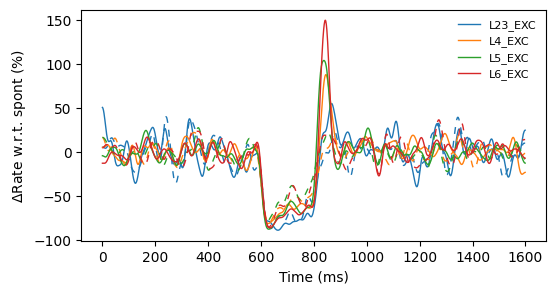

In [8]:
# Plot rates by layer
plot_window = "w_all"
ref_window = "w1_spont"
sim_idx = len(cond_val) - 1
bin_size = 5 # (ms)
smoothing_type = "Gaussian"
kernel_sd = 10.0

# mav_len = 500
colors = plt.cm.tab10(np.linspace(0, 1, 10))
styles = ["-", (0, (5, 5))]
plt.figure(figsize=(6, 3))
for cidx, nrn_class in enumerate(["L23_EXC", "L4_EXC", "L5_EXC", "L6_EXC"]):
# for cidx, nrn_class in enumerate(["Stim_L23_INH", "Stim_L4_INH", "Stim_L5_INH", "Stim_L6_INH"]):
# for cidx, nrn_class in enumerate(["NoStim_L1_INH", "NoStim_L23_INH", "NoStim_L4_INH", "NoStim_L5_INH", "NoStim_L6_INH"]):
    for didx, df_sel in enumerate([hist_df_orig, hist_df_manip]):
        # h_ref = df_sel.etl.q(simulation_id=sim_idx, neuron_class=nrn_class, window=ref_window)[f"spike_times_normalised_hist_{bin_size}ms_bin"].values.mean()
        # h_data = df_sel.etl.q(simulation_id=sim_idx, neuron_class=nrn_class, window=plot_window)[f"spike_times_normalised_hist_{bin_size}ms_bin"].values
        h_ref = df_sel.etl.q(simulation_id=sim_idx, neuron_class=nrn_class, window=ref_window, bin_size=bin_size, smoothing_type=smoothing_type, kernel_sd=kernel_sd)["hist"].values.mean()
        h_data = df_sel.etl.q(simulation_id=sim_idx, neuron_class=nrn_class, window=plot_window, bin_size=bin_size, smoothing_type=smoothing_type, kernel_sd=kernel_sd)["hist"].values

#         h_data = h_data / (bin_size * 1e-3)
        h_data = 100.0 * (h_data - h_ref) / h_ref
        # h_data = scipy.ndimage.convolve1d(h_data, np.ones(mav_len) / mav_len)
        plt.plot(h_data, linestyle=styles[didx], color=colors[cidx, :], alpha=1.0, lw=1.0, label=nrn_class if not didx else None)
    plt.xlabel("Time (ms)")
    plt.ylabel("$\Delta$Rate w.r.t. spont (%)")
plt.legend(frameon=False, fontsize=8)
plt.show()

In [9]:
# Run significance test between orig/manip
from scipy.stats import ranksums
import tqdm

def get_norm_signal(hist_df, ref_window="w1_spont", data_window="w_all"):
    """Normalize data window signal w.r.t. ref window."""
    h_ref = hist_df.etl.q(window=ref_window).values.mean()
    h_data = hist_df.etl.q(window=data_window).values
    return (h_data - h_ref) / h_ref

def sliding_ranksums(s1, s2, N_wnd=1000):
    """Sliding window Wilcoxon rank-sum statistic for two samples.
       s1, s2 ... Signals to test
       N_wnd  ... Sliding window length in samples (window centered)"""
    assert len(s1) == len(s2), "ERROR: Signal length mismatch!"
    p_val = np.full_like(s1, np.nan)
    il = np.round(N_wnd / 2).astype(int)  # Left index offset
    ir = N_wnd - il  # Right index offset
    for i in tqdm.tqdm(range(len(s1))):
        w1 = s1[np.maximum(i - il, 0) : np.minimum(i + ir, len(s1))]
        w2 = s2[np.maximum(i - il, 0) : np.minimum(i + ir, len(s1))]
        p_val[i] = ranksums(w1, w2).pvalue
    return p_val

sim_idx = len(cond_val) - 1
data_window = "w_all"
bin_size = 5 # (ms)
smoothing_type = "Gaussian"
kernel_sd = 1.0
# nrn_class = "ALL_EXC"
nrn_class = "NoStim_INH"
r1 = get_norm_signal(hist_df_orig.etl.q(simulation_id=sim_idx, neuron_class=nrn_class, bin_size=bin_size, smoothing_type=smoothing_type, kernel_sd=kernel_sd)["hist"], data_window=data_window)
r2 = get_norm_signal(hist_df_manip.etl.q(simulation_id=sim_idx, neuron_class=nrn_class, bin_size=bin_size, smoothing_type=smoothing_type, kernel_sd=kernel_sd)["hist"], data_window=data_window)
# r1 = get_norm_signal(hist_df_orig.etl.q(simulation_id=sim_idx, neuron_class=nrn_class)[f"spike_times_normalised_hist_{bin_size}ms_bin"])
# r2 = get_norm_signal(hist_df_manip.etl.q(simulation_id=sim_idx, neuron_class=nrn_class)[f"spike_times_normalised_hist_{bin_size}ms_bin"])
# r1 = hist_df_orig.etl.q(simulation_id=sim_idx, neuron_class=nrn_class, window="w_all")[f"spike_times_normalised_hist_{bin_size}ms_bin"].values
# r2 = hist_df_manip.etl.q(simulation_id=sim_idx, neuron_class=nrn_class, window="w_all")[f"spike_times_normalised_hist_{bin_size}ms_bin"].values
p_val = sliding_ranksums(r1, r2, N_wnd=200)
window = ma_orig.spikes.extraction.windows.get_bounds(data_window)
t = np.arange(*window, bin_size) + 0.5 * bin_size

100%|██████████| 1600/1600 [00:01<00:00, 935.51it/s] 


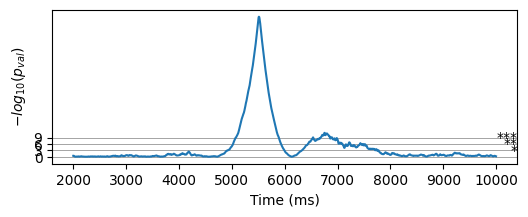

In [10]:
alpha = np.array([10**-e for e in [0, 3, 6, 9]])
plt.figure(figsize=(6, 2))
plt.plot(t, -np.log10(p_val))
plt.xlim(plt.xlim())
plt.hlines(-np.log10(alpha), *plt.xlim(), color='k', zorder=0, lw=0.5, alpha=0.5)
for i, a in enumerate(alpha):
    plt.text(np.max(plt.xlim()), -np.log10(a), "*" * i, ha="right", va="center")
plt.yticks(-np.log10(alpha))
plt.xlabel("Time (ms)")
plt.ylabel("$-log_{10}(p_{val})$")
plt.show()

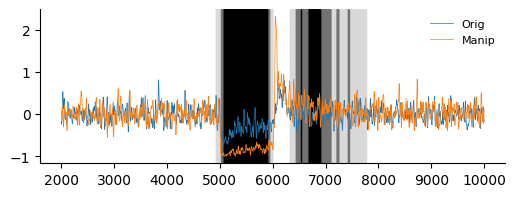

In [11]:
def p_sel(p_val, a_level):
    p_sel = (p_val < a_level).astype(float)
    p_sel[p_sel == 0.0] = np.nan
    return p_sel

acolors = plt.cm.Greys(np.linspace(0.25, 1, len(alpha) - 1))

plt.figure(figsize=(6, 2))
plt.plot(t, r1, lw=0.5, label="Orig")
plt.plot(t, r2, lw=0.5, label="Manip")
# plt.gca().spines['bottom'].set_zorder(-1000)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylim(plt.ylim())
for i, a in enumerate(alpha[1:]):
    # plt.plot(p_sel(p_val, a) * np.max(plt.ylim()), color=acolors[i, :], lw=3, clip_on=False, zorder=0)
    plt.vlines(t[np.isfinite(p_sel(p_val, a))], *plt.ylim(), color=acolors[i, :], lw=1, zorder=0)
plt.legend(frameon=False, fontsize=8)
plt.show()

In [12]:
# E/I correlation
from scipy.stats import linregress

corr_window = "w1_spont"
corr_bin_size = 3.0
corr_smoothing_type = 'Gaussian'
corr_kernel_sd = 1.0

corr_layers = ["L23", "L4", "L5", "L6"]
sim_idx = len(cond_val) - 1

ei_corr_rvalues = {}
for df_sel, df_name in zip([hist_df_orig, hist_df_manip], ["Orig", "Manip"]):
    rvalues = []
    for lay in corr_layers:
        exc_data = df_sel.etl.q(simulation_id=sim_idx, neuron_class=f"{lay}_EXC", window=corr_window, bin_size=corr_bin_size, smoothing_type=corr_smoothing_type, kernel_sd=corr_kernel_sd)["hist"].values
        inh_data = df_sel.etl.q(simulation_id=sim_idx, neuron_class=f"{lay}_INH", window=corr_window, bin_size=corr_bin_size, smoothing_type=corr_smoothing_type, kernel_sd=corr_kernel_sd)["hist"].values
        rvalues.append(linregress(exc_data, inh_data).rvalue)
    ei_corr_rvalues[df_name] = rvalues

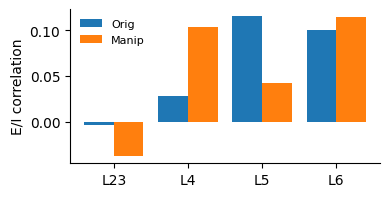

In [13]:
w = {"Orig": -0.4, "Manip": 0.4}
plt.figure(figsize=(4, 2))
for lbl, rvalues in ei_corr_rvalues.items():
    plt.bar(corr_layers, rvalues, align="edge", width=w[lbl], label=lbl)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylabel("E/I correlation")
plt.legend(frameon=False, fontsize=8)
plt.show()